In [1]:
from time import time
import pickle
import os
import numpy as np
from adaptive.experiment import run_mab_experiment
from adaptive.compute import fill_up, collect
from adaptive.inference import aw_scores, sample_mean
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(font_scale=1.2)
%matplotlib inline
%reload_ext autoreload
%autoreload 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Introduction Example

DGP: run a contextual bandit experiment with a Thompson sampling agent, collecting $1000$ observations for one simulation.  
- context space $\{x_0, x_1, x_2, x_3, x_4\}$ with probability $[0.6, 0.1, 0.1, 0.1]$. 
- arms: $\{w_0, w_1, w_2, w_3, w_4\}$ 
- potential outcomes of $x_i$ assigned to $w_j$: $0.5\cdot 1_{i=j} + \mathcal{N}(0,1)$
- agent: Thompson sampling with floor $0.2t^{-0.7}$

Target policy: always assigning treatment $W_t=w_0$.

Compared estimators: Direct Method (DM) and Doubly Robust (DR).

In [2]:
K = 5  # number of arms
N = 5  # number of different context
initial = 2  # initial number of samples of each arm to do pure exploration
floor_start = 1/K
floor_decay = 0.7
noise_scale = 1.0
signal = 0.5
T = 1000

In [3]:
p_X = [0.6, 0.1, 0.1, 0.1, 0.1]
truth = np.eye(K) * signal
w_optimal_X = np.eye(K)
mu_K = np.transpose(truth).dot(p_X)

In [4]:
arm=0
sim = 1000
DM = []
AIPW = []

## Run simulations

In [5]:
Probs = []
for _ in range(sim):
    """ Generate data """
    xs = np.random.choice(a=N, size=T, p=p_X)
    noise = np.random.normal(loc=0.0, scale=noise_scale, size=(T, K))
    #noise = np.random.uniform(-noise_scale, noise_scale, size=(T, K))
    #R = noise_scale * 2
    ys = truth[xs] + noise
    """ Run experiment """
    probs = np.zeros((T, N, K))
    rewards = np.zeros(T)
    arms = np.zeros(T, dtype=np.int)
    muhat = np.zeros((T, K))
    for n in range(N):
        idx = xs == n
        data = run_mab_experiment(
            ys[idx],
            initial=initial,
            floor_start=floor_start,
            floor_decay=floor_decay)
        P = data['probs']
        idx_a = np.where(xs == n)[0]
        if idx_a[-1] < T-1:
            idx_a = np.concatenate([idx_a, [T-1]])
            P = np.concatenate([P, [data['future_p']]], axis=0)
        probs[:, n, :] = fill_up(T, idx_a, P)
        rewards[idx] = data['rewards']
        arms[idx] = data['arms']
        muhat[idx] = sample_mean(rewards[idx], arms[idx], K)[-1]
    balwts = 1 / collect(probs[np.arange(T), xs], arms)
    scores = aw_scores(rewards, arms, balwts, K, muhat)
    # add best arm policy
    Probs.append(probs[:, :, arm])
    best_mtx = np.zeros((T, K))
    best_mtx[:, arm] = 1
    qx = truth[:, arm] * p_X
    DM.append(np.mean(np.sum(muhat * best_mtx, axis=1)))
    AIPW.append(np.mean(np.sum(scores * best_mtx, axis=1)))

/opt/anaconda3/envs/aw_contextual/lib/python3.7/site-packages/ipykernel-6.13.0-py3.7.egg/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == "":


## Boxplot of estimates of DM and DR

DM bias: -0.07432431638084572, std: 0.10326780108957512
AIPW bias: -0.00843135085124569, std: 0.14946230623697038


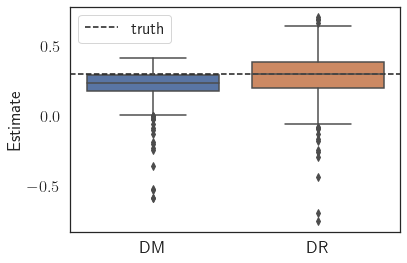

In [7]:
print(f"DM bias: {np.mean(DM) - mu_K[arm]}, std: {np.std(DM)}")
print(f"AIPW bias: {np.mean(AIPW) - mu_K[arm]}, std: {np.std(AIPW)}")
dataset_1 = pd.DataFrame({'method':['DM']*len(DM), 'eval': np.array(DM)})
dataset_2 = pd.DataFrame({'method':['DR']*len(AIPW), 'eval': np.array(AIPW)})
dataset = pd.concat([dataset_1, dataset_2])
sns.set(style='white', font_scale=1.5)
f, ax = plt.subplots()
ax.axhline(y=mu_K[arm], color='k', linestyle='--', label='truth')
sns.boxplot(x='method', y='eval', data=dataset)
ax.set_xlabel('')
ax.legend()
ax.set_ylabel('Estimate')
plt.tight_layout()
plt.savefig('intro.pdf')

## Evolution of variance proxy over time with different covariates

ValueError: cannot reindex from a duplicate axis

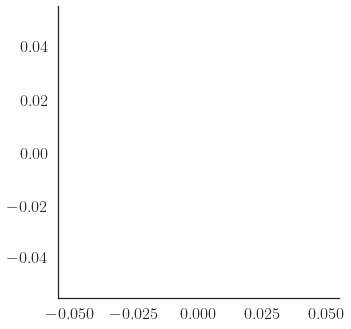

In [8]:
sns.set_context(font_scale=2)
cond_var = 1 / np.array(Probs)
idx = np.arange(0,T,T//100)
df = []
for i in range(K):
    df.append(pd.DataFrame({'$1/e_t$': np.concatenate(cond_var[:, idx, i], axis=0), 't': np.tile(idx, sim), 
                            'Value':[str(i)]*(len(idx)*sim), 'Style':[0]*(len(idx)*sim)}))
df.append(pd.DataFrame({'$1/e_t$': np.concatenate(cond_var[:, idx, :], axis=0).dot(p_X), 't': np.tile(idx, sim), 
                        'Value':['E']*(len(idx)*sim), 'Style':[1]*(len(idx)*sim)}))
df = pd.concat(df)
hue_order = [str(i) for i in range(K)]
hue_order.append('E')
g = sns.relplot(data=df, kind='line', x='t', y='$1/e_t$', hue='Value', 
                aspect=1.0, 
                hue_order=hue_order,
                palette=[*sns.color_palette()[:K], 'k'],
                style='Style',
               )
for ax in g.axes.flat:
    #ax.set_yscale('log')
    handles, labels = ax.get_legend_handles_labels()
g.set_ylabels("Variance proxy")
g.set_xlabels("t")
handles = [*handles[1:(K+1)], handles[-1]]
labels_X = [f'$x_{i}$' for i in range(K)]
labels =  [
           *labels_X, 
           '$E_x$']
g._legend.remove()
g.fig.tight_layout()
g.fig.legend(labels=labels, handles=handles, fontsize=18, loc='center left', frameon=False, bbox_to_anchor=(0.95, 0.5) )
plt.savefig('motivation_contextual.pdf', bbox_inches='tight')

ValueError: cannot reindex from a duplicate axis

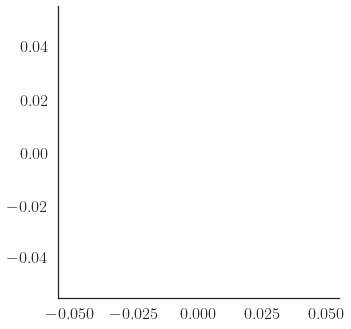

In [11]:
g = sns.relplot(data=df, kind='line', x='t', y='$1/e_t$', hue='Value',
                aspect=1.0,
                hue_order=hue_order,
                palette=[*sns.color_palette()[:K], 'k'],
                style='Style',
               )

In [14]:
data=df
kind='line'
x='t'
y='$1/e_t$'
hue='Value'
aspect=1.0
hue_order=hue_order
palette=[*sns.color_palette()[:K], 'k']
style='Style'

In [15]:
data.head()

,$1/e_t$,t,Value,Style
0,5.000000,0,0,0
1,5.000000,10,0,0
2,4.368584,20,0,0
3,2.630971,30,0,0
4,1.424438,40,0,0


In [13]:
df.head()

,$1/e_t$,t,Value,Style
0,5.000000,0,0,0
1,5.000000,10,0,0
2,4.368584,20,0,0
3,2.630971,30,0,0
4,1.424438,40,0,0


In [16]:
hue=None
size=None
style=None
row=None
col=None
col_wrap=None
row_order=None
col_order=None
palette=None
hue_order=None
hue_norm=None
sizes=None
size_order=None
size_norm=None
markers=None
dashes=None
style_order=None
legend="auto"
# kind="scatter"
height=5
aspect=1
facet_kws=None
units=None
data=df
kind='line'
x='t'
y='$1/e_t$'
hue='Value'
aspect=1.0
hue_order=hue_order
palette=[*sns.color_palette()[:K], 'k']
style='Style'

In [19]:
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from ._core import (
    VectorPlotter,
)
from .utils import (
    ci_to_errsize,
    locator_to_legend_entries,
    adjust_legend_subtitles,
    ci as ci_func
)
from .algorithms import bootstrap
from .axisgrid import FacetGrid, _facet_docs
from ._decorators import _deprecate_positional_args
from ._docstrings import (
    DocstringComponents,
    _core_docs,
)


__all__ = ["relplot", "scatterplot", "lineplot"]


_relational_narrative = DocstringComponents(dict(

    # ---  Introductory prose
    main_api="""
The relationship between ``x`` and ``y`` can be shown for different subsets
of the data using the ``hue``, ``size``, and ``style`` parameters. These
parameters control what visual semantics are used to identify the different
subsets. It is possible to show up to three dimensions independently by
using all three semantic types, but this style of plot can be hard to
interpret and is often ineffective. Using redundant semantics (i.e. both
``hue`` and ``style`` for the same variable) can be helpful for making
graphics more accessible.

See the :ref:`tutorial <relational_tutorial>` for more information.
    """,

    relational_semantic="""
The default treatment of the ``hue`` (and to a lesser extent, ``size``)
semantic, if present, depends on whether the variable is inferred to
represent "numeric" or "categorical" data. In particular, numeric variables
are represented with a sequential colormap by default, and the legend
entries show regular "ticks" with values that may or may not exist in the
data. This behavior can be controlled through various parameters, as
described and illustrated below.
    """,
))

_relational_docs = dict(

    # --- Shared function parameters
    data_vars="""
x, y : names of variables in ``data`` or vector data
    Input data variables; must be numeric. Can pass data directly or
    reference columns in ``data``.
    """,
    data="""
data : DataFrame, array, or list of arrays
    Input data structure. If ``x`` and ``y`` are specified as names, this
    should be a "long-form" DataFrame containing those columns. Otherwise
    it is treated as "wide-form" data and grouping variables are ignored.
    See the examples for the various ways this parameter can be specified
    and the different effects of each.
    """,
    palette="""
palette : string, list, dict, or matplotlib colormap
    An object that determines how colors are chosen when ``hue`` is used.
    It can be the name of a seaborn palette or matplotlib colormap, a list
    of colors (anything matplotlib understands), a dict mapping levels
    of the ``hue`` variable to colors, or a matplotlib colormap object.
    """,
    hue_order="""
hue_order : list
    Specified order for the appearance of the ``hue`` variable levels,
    otherwise they are determined from the data. Not relevant when the
    ``hue`` variable is numeric.
    """,
    hue_norm="""
hue_norm : tuple or :class:`matplotlib.colors.Normalize` object
    Normalization in data units for colormap applied to the ``hue``
    variable when it is numeric. Not relevant if it is categorical.
    """,
    sizes="""
sizes : list, dict, or tuple
    An object that determines how sizes are chosen when ``size`` is used.
    It can always be a list of size values or a dict mapping levels of the
    ``size`` variable to sizes. When ``size``  is numeric, it can also be
    a tuple specifying the minimum and maximum size to use such that other
    values are normalized within this range.
    """,
    size_order="""
size_order : list
    Specified order for appearance of the ``size`` variable levels,
    otherwise they are determined from the data. Not relevant when the
    ``size`` variable is numeric.
    """,
    size_norm="""
size_norm : tuple or Normalize object
    Normalization in data units for scaling plot objects when the
    ``size`` variable is numeric.
    """,
    dashes="""
dashes : boolean, list, or dictionary
    Object determining how to draw the lines for different levels of the
    ``style`` variable. Setting to ``True`` will use default dash codes, or
    you can pass a list of dash codes or a dictionary mapping levels of the
    ``style`` variable to dash codes. Setting to ``False`` will use solid
    lines for all subsets. Dashes are specified as in matplotlib: a tuple
    of ``(segment, gap)`` lengths, or an empty string to draw a solid line.
    """,
    markers="""
markers : boolean, list, or dictionary
    Object determining how to draw the markers for different levels of the
    ``style`` variable. Setting to ``True`` will use default markers, or
    you can pass a list of markers or a dictionary mapping levels of the
    ``style`` variable to markers. Setting to ``False`` will draw
    marker-less lines.  Markers are specified as in matplotlib.
    """,
    style_order="""
style_order : list
    Specified order for appearance of the ``style`` variable levels
    otherwise they are determined from the data. Not relevant when the
    ``style`` variable is numeric.
    """,
    units="""
units : vector or key in ``data``
    Grouping variable identifying sampling units. When used, a separate
    line will be drawn for each unit with appropriate semantics, but no
    legend entry will be added. Useful for showing distribution of
    experimental replicates when exact identities are not needed.
    """,
    estimator="""
estimator : name of pandas method or callable or None
    Method for aggregating across multiple observations of the ``y``
    variable at the same ``x`` level. If ``None``, all observations will
    be drawn.
    """,
    ci="""
ci : int or "sd" or None
    Size of the confidence interval to draw when aggregating with an
    estimator. "sd" means to draw the standard deviation of the data.
    Setting to ``None`` will skip bootstrapping.
    """,
    n_boot="""
n_boot : int
    Number of bootstraps to use for computing the confidence interval.
    """,
    seed="""
seed : int, numpy.random.Generator, or numpy.random.RandomState
    Seed or random number generator for reproducible bootstrapping.
    """,
    legend="""
legend : "auto", "brief", "full", or False
    How to draw the legend. If "brief", numeric ``hue`` and ``size``
    variables will be represented with a sample of evenly spaced values.
    If "full", every group will get an entry in the legend. If "auto",
    choose between brief or full representation based on number of levels.
    If ``False``, no legend data is added and no legend is drawn.
    """,
    ax_in="""
ax : matplotlib Axes
    Axes object to draw the plot onto, otherwise uses the current Axes.
    """,
    ax_out="""
ax : matplotlib Axes
    Returns the Axes object with the plot drawn onto it.
    """,

)


_param_docs = DocstringComponents.from_nested_components(
    core=_core_docs["params"],
    facets=DocstringComponents(_facet_docs),
    rel=DocstringComponents(_relational_docs),
)


class _RelationalPlotter(VectorPlotter):

    wide_structure = {
        "x": "@index", "y": "@values", "hue": "@columns", "style": "@columns",
    }

    # TODO where best to define default parameters?
    sort = True

    def add_legend_data(self, ax):
        """Add labeled artists to represent the different plot semantics."""
        verbosity = self.legend
        if isinstance(verbosity, str) and verbosity not in ["auto", "brief", "full"]:
            err = "`legend` must be 'auto', 'brief', 'full', or a boolean."
            raise ValueError(err)
        elif verbosity is True:
            verbosity = "auto"

        legend_kwargs = {}
        keys = []

        # Assign a legend title if there is only going to be one sub-legend,
        # otherwise, subtitles will be inserted into the texts list with an
        # invisible handle (which is a hack)
        titles = {
            title for title in
            (self.variables.get(v, None) for v in ["hue", "size", "style"])
            if title is not None
        }
        if len(titles) == 1:
            legend_title = titles.pop()
        else:
            legend_title = ""

        title_kws = dict(
            visible=False, color="w", s=0, linewidth=0, marker="", dashes=""
        )

        def update(var_name, val_name, **kws):

            key = var_name, val_name
            if key in legend_kwargs:
                legend_kwargs[key].update(**kws)
            else:
                keys.append(key)

                legend_kwargs[key] = dict(**kws)

        # Define the maximum number of ticks to use for "brief" legends
        brief_ticks = 6

        # -- Add a legend for hue semantics
        brief_hue = self._hue_map.map_type == "numeric" and (
            verbosity == "brief"
            or (verbosity == "auto" and len(self._hue_map.levels) > brief_ticks)
        )
        if brief_hue:
            if isinstance(self._hue_map.norm, mpl.colors.LogNorm):
                locator = mpl.ticker.LogLocator(numticks=brief_ticks)
            else:
                locator = mpl.ticker.MaxNLocator(nbins=brief_ticks)
            limits = min(self._hue_map.levels), max(self._hue_map.levels)
            hue_levels, hue_formatted_levels = locator_to_legend_entries(
                locator, limits, self.plot_data["hue"].infer_objects().dtype
            )
        elif self._hue_map.levels is None:
            hue_levels = hue_formatted_levels = []
        else:
            hue_levels = hue_formatted_levels = self._hue_map.levels

        # Add the hue semantic subtitle
        if not legend_title and self.variables.get("hue", None) is not None:
            update((self.variables["hue"], "title"),
                   self.variables["hue"], **title_kws)

        # Add the hue semantic labels
        for level, formatted_level in zip(hue_levels, hue_formatted_levels):
            if level is not None:
                color = self._hue_map(level)
                update(self.variables["hue"], formatted_level, color=color)

        # -- Add a legend for size semantics
        brief_size = self._size_map.map_type == "numeric" and (
            verbosity == "brief"
            or (verbosity == "auto" and len(self._size_map.levels) > brief_ticks)
        )
        if brief_size:
            # Define how ticks will interpolate between the min/max data values
            if isinstance(self._size_map.norm, mpl.colors.LogNorm):
                locator = mpl.ticker.LogLocator(numticks=brief_ticks)
            else:
                locator = mpl.ticker.MaxNLocator(nbins=brief_ticks)
            # Define the min/max data values
            limits = min(self._size_map.levels), max(self._size_map.levels)
            size_levels, size_formatted_levels = locator_to_legend_entries(
                locator, limits, self.plot_data["size"].infer_objects().dtype
            )
        elif self._size_map.levels is None:
            size_levels = size_formatted_levels = []
        else:
            size_levels = size_formatted_levels = self._size_map.levels

        # Add the size semantic subtitle
        if not legend_title and self.variables.get("size", None) is not None:
            update((self.variables["size"], "title"),
                   self.variables["size"], **title_kws)

        # Add the size semantic labels
        for level, formatted_level in zip(size_levels, size_formatted_levels):
            if level is not None:
                size = self._size_map(level)
                update(
                    self.variables["size"],
                    formatted_level,
                    linewidth=size,
                    s=size,
                )

        # -- Add a legend for style semantics

        # Add the style semantic title
        if not legend_title and self.variables.get("style", None) is not None:
            update((self.variables["style"], "title"),
                   self.variables["style"], **title_kws)

        # Add the style semantic labels
        if self._style_map.levels is not None:
            for level in self._style_map.levels:
                if level is not None:
                    attrs = self._style_map(level)
                    update(
                        self.variables["style"],
                        level,
                        marker=attrs.get("marker", ""),
                        dashes=attrs.get("dashes", ""),
                    )

        func = getattr(ax, self._legend_func)

        legend_data = {}
        legend_order = []

        for key in keys:

            _, label = key
            kws = legend_kwargs[key]
            kws.setdefault("color", ".2")
            use_kws = {}
            for attr in self._legend_attributes + ["visible"]:
                if attr in kws:
                    use_kws[attr] = kws[attr]
            artist = func([], [], label=label, **use_kws)
            if self._legend_func == "plot":
                artist = artist[0]
            legend_data[key] = artist
            legend_order.append(key)

        self.legend_title = legend_title
        self.legend_data = legend_data
        self.legend_order = legend_order


class _LinePlotter(_RelationalPlotter):

    _legend_attributes = ["color", "linewidth", "marker", "dashes"]
    _legend_func = "plot"

    def __init__(
        self, *,
        data=None, variables={},
        estimator=None, ci=None, n_boot=None, seed=None,
        sort=True, err_style=None, err_kws=None, legend=None
    ):

        # TODO this is messy, we want the mapping to be agnoistic about
        # the kind of plot to draw, but for the time being we need to set
        # this information so the SizeMapping can use it
        self._default_size_range = (
            np.r_[.5, 2] * mpl.rcParams["lines.linewidth"]
        )

        super().__init__(data=data, variables=variables)

        self.estimator = estimator
        self.ci = ci
        self.n_boot = n_boot
        self.seed = seed
        self.sort = sort
        self.err_style = err_style
        self.err_kws = {} if err_kws is None else err_kws

        self.legend = legend

    def aggregate(self, vals, grouper, units=None):
        """Compute an estimate and confidence interval using grouper."""
        func = self.estimator
        ci = self.ci
        n_boot = self.n_boot
        seed = self.seed

        # Define a "null" CI for when we only have one value
        null_ci = pd.Series(index=["low", "high"], dtype=float)

        # Function to bootstrap in the context of a pandas group by
        def bootstrapped_cis(vals):

            if len(vals) <= 1:
                return null_ci

            boots = bootstrap(vals, func=func, n_boot=n_boot, seed=seed)
            cis = ci_func(boots, ci)
            return pd.Series(cis, ["low", "high"])

        # Group and get the aggregation estimate
        grouped = vals.groupby(grouper, sort=self.sort)
        est = grouped.agg(func)

        # Exit early if we don't want a confidence interval
        if ci is None:
            return est.index, est, None

        # Compute the error bar extents
        if ci == "sd":
            sd = grouped.std()
            cis = pd.DataFrame(np.c_[est - sd, est + sd],
                               index=est.index,
                               columns=["low", "high"]).stack()
        else:
            cis = grouped.apply(bootstrapped_cis)

        # Unpack the CIs into "wide" format for plotting
        if cis.notnull().any():
            cis = cis.unstack().reindex(est.index)
        else:
            cis = None

        return est.index, est, cis

    def plot(self, ax, kws):
        """Draw the plot onto an axes, passing matplotlib kwargs."""

        # Draw a test plot, using the passed in kwargs. The goal here is to
        # honor both (a) the current state of the plot cycler and (b) the
        # specified kwargs on all the lines we will draw, overriding when
        # relevant with the data semantics. Note that we won't cycle
        # internally; in other words, if ``hue`` is not used, all elements will
        # have the same color, but they will have the color that you would have
        # gotten from the corresponding matplotlib function, and calling the
        # function will advance the axes property cycle.

        scout, = ax.plot([], [], **kws)

        orig_color = kws.pop("color", scout.get_color())
        orig_marker = kws.pop("marker", scout.get_marker())
        orig_linewidth = kws.pop("linewidth",
                                 kws.pop("lw", scout.get_linewidth()))

        # Note that scout.get_linestyle() is` not correct as of mpl 3.2
        orig_linestyle = kws.pop("linestyle", kws.pop("ls", None))

        kws.setdefault("markeredgewidth", kws.pop("mew", .75))
        kws.setdefault("markeredgecolor", kws.pop("mec", "w"))

        scout.remove()

        # Set default error kwargs
        err_kws = self.err_kws.copy()
        if self.err_style == "band":
            err_kws.setdefault("alpha", .2)
        elif self.err_style == "bars":
            pass
        elif self.err_style is not None:
            err = "`err_style` must be 'band' or 'bars', not {}"
            raise ValueError(err.format(self.err_style))

        # Set the default artist keywords
        kws.update(dict(
            color=orig_color,
            marker=orig_marker,
            linewidth=orig_linewidth,
            linestyle=orig_linestyle,
        ))

        # Loop over the semantic subsets and add to the plot
        grouping_vars = "hue", "size", "style"
        for sub_vars, sub_data in self.iter_data(grouping_vars, from_comp_data=True):

            if self.sort:
                sort_vars = ["units", "x", "y"]
                sort_cols = [var for var in sort_vars if var in self.variables]
                sub_data = sub_data.sort_values(sort_cols)

            # TODO
            # How to handle NA? We don't want NA to propagate through to the
            # estimate/CI when some values are present, but we would also like
            # matplotlib to show "gaps" in the line when all values are missing.
            # This is straightforward absent aggregation, but complicated with it.
            sub_data = sub_data.dropna()

            # Due to the original design, code below was written assuming that
            # sub_data always has x, y, and units columns, which may be empty.
            # Adding this here to avoid otherwise disruptive changes, but it
            # could get removed if the rest of the logic is sorted out
            null = pd.Series(index=sub_data.index, dtype=float)

            x = sub_data.get("x", null)
            y = sub_data.get("y", null)
            u = sub_data.get("units", null)

            if self.estimator is not None:
                if "units" in self.variables:
                    err = "estimator must be None when specifying units"
                    raise ValueError(err)
                x, y, y_ci = self.aggregate(y, x, u)
            else:
                y_ci = None

            if "hue" in sub_vars:
                kws["color"] = self._hue_map(sub_vars["hue"])
            if "size" in sub_vars:
                kws["linewidth"] = self._size_map(sub_vars["size"])
            if "style" in sub_vars:
                attributes = self._style_map(sub_vars["style"])
                if "dashes" in attributes:
                    kws["dashes"] = attributes["dashes"]
                if "marker" in attributes:
                    kws["marker"] = attributes["marker"]

            line, = ax.plot([], [], **kws)
            line_color = line.get_color()
            line_alpha = line.get_alpha()
            line_capstyle = line.get_solid_capstyle()
            line.remove()

            # --- Draw the main line

            x, y = np.asarray(x), np.asarray(y)

            if "units" in self.variables:
                for u_i in u.unique():
                    rows = np.asarray(u == u_i)
                    ax.plot(x[rows], y[rows], **kws)
            else:
                line, = ax.plot(x, y, **kws)

            # --- Draw the confidence intervals

            if y_ci is not None:

                low, high = np.asarray(y_ci["low"]), np.asarray(y_ci["high"])

                if self.err_style == "band":

                    ax.fill_between(x, low, high, color=line_color, **err_kws)

                elif self.err_style == "bars":

                    y_err = ci_to_errsize((low, high), y)
                    ebars = ax.errorbar(x, y, y_err, linestyle="",
                                        color=line_color, alpha=line_alpha,
                                        **err_kws)

                    # Set the capstyle properly on the error bars
                    for obj in ebars.get_children():
                        try:
                            obj.set_capstyle(line_capstyle)
                        except AttributeError:
                            # Does not exist on mpl < 2.2
                            pass

        # Finalize the axes details
        self._add_axis_labels(ax)
        if self.legend:
            self.add_legend_data(ax)
            handles, _ = ax.get_legend_handles_labels()
            if handles:
                legend = ax.legend(title=self.legend_title)
                adjust_legend_subtitles(legend)


class _ScatterPlotter(_RelationalPlotter):

    _legend_attributes = ["color", "s", "marker"]
    _legend_func = "scatter"

    def __init__(
        self, *,
        data=None, variables={},
        x_bins=None, y_bins=None,
        estimator=None, ci=None, n_boot=None,
        alpha=None, x_jitter=None, y_jitter=None,
        legend=None
    ):

        # TODO this is messy, we want the mapping to be agnoistic about
        # the kind of plot to draw, but for the time being we need to set
        # this information so the SizeMapping can use it
        self._default_size_range = (
            np.r_[.5, 2] * np.square(mpl.rcParams["lines.markersize"])
        )

        super().__init__(data=data, variables=variables)

        self.alpha = alpha
        self.legend = legend

    def plot(self, ax, kws):

        # Draw a test plot, using the passed in kwargs. The goal here is to
        # honor both (a) the current state of the plot cycler and (b) the
        # specified kwargs on all the lines we will draw, overriding when
        # relevant with the data semantics. Note that we won't cycle
        # internally; in other words, if ``hue`` is not used, all elements will
        # have the same color, but they will have the color that you would have
        # gotten from the corresponding matplotlib function, and calling the
        # function will advance the axes property cycle.

        scout_size = max(
            np.atleast_1d(kws.get("s", [])).shape[0],
            np.atleast_1d(kws.get("c", [])).shape[0],
        )
        scout_x = scout_y = np.full(scout_size, np.nan)
        scout = ax.scatter(scout_x, scout_y, **kws)
        s = kws.pop("s", scout.get_sizes())
        c = kws.pop("c", scout.get_facecolors())
        scout.remove()

        kws.pop("color", None)  # TODO is this optimal?

        # --- Determine the visual attributes of the plot

        data = self.plot_data[list(self.variables)].dropna()
        if not data.size:
            return

        # Define the vectors of x and y positions
        empty = np.full(len(data), np.nan)
        x = data.get("x", empty)
        y = data.get("y", empty)

        # Apply the mapping from semantic variables to artist attributes
        if "hue" in self.variables:
            c = self._hue_map(data["hue"])

        if "size" in self.variables:
            s = self._size_map(data["size"])

        # Set defaults for other visual attributes
        kws.setdefault("linewidth", .08 * np.sqrt(np.percentile(s, 10)))

        if "style" in self.variables:
            # Use a representative marker so scatter sets the edgecolor
            # properly for line art markers. We currently enforce either
            # all or none line art so this works.
            example_level = self._style_map.levels[0]
            example_marker = self._style_map(example_level, "marker")
            kws.setdefault("marker", example_marker)

        # Conditionally set the marker edgecolor based on whether the marker is "filled"
        # See https://github.com/matplotlib/matplotlib/issues/17849 for context
        m = kws.get("marker", mpl.rcParams.get("marker", "o"))
        if not isinstance(m, mpl.markers.MarkerStyle):
            m = mpl.markers.MarkerStyle(m)
        if m.is_filled():
            kws.setdefault("edgecolor", "w")

        # TODO this makes it impossible to vary alpha with hue which might
        # otherwise be useful? Should we just pass None?
        kws["alpha"] = 1 if self.alpha == "auto" else self.alpha

        # Draw the scatter plot
        args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
        points = ax.scatter(*args, **kws)

        # Update the paths to get different marker shapes.
        # This has to be done here because ax.scatter allows varying sizes
        # and colors but only a single marker shape per call.
        if "style" in self.variables:
            p = [self._style_map(val, "path") for val in data["style"]]
            points.set_paths(p)

        # Finalize the axes details
        self._add_axis_labels(ax)
        if self.legend:
            self.add_legend_data(ax)
            handles, _ = ax.get_legend_handles_labels()
            if handles:
                legend = ax.legend(title=self.legend_title)
                adjust_legend_subtitles(legend)


@_deprecate_positional_args
def lineplot(
    *,
    x=None, y=None,
    hue=None, size=None, style=None,
    data=None,
    palette=None, hue_order=None, hue_norm=None,
    sizes=None, size_order=None, size_norm=None,
    dashes=True, markers=None, style_order=None,
    units=None, estimator="mean", ci=95, n_boot=1000, seed=None,
    sort=True, err_style="band", err_kws=None,
    legend="auto", ax=None, **kwargs
):

    variables = _LinePlotter.get_semantics(locals())
    p = _LinePlotter(
        data=data, variables=variables,
        estimator=estimator, ci=ci, n_boot=n_boot, seed=seed,
        sort=sort, err_style=err_style, err_kws=err_kws, legend=legend,
    )

    p.map_hue(palette=palette, order=hue_order, norm=hue_norm)
    p.map_size(sizes=sizes, order=size_order, norm=size_norm)
    p.map_style(markers=markers, dashes=dashes, order=style_order)

    if ax is None:
        ax = plt.gca()

    if not p.has_xy_data:
        return ax

    p._attach(ax)

    p.plot(ax, kwargs)
    return ax


lineplot.__doc__ = """\
Draw a line plot with possibility of several semantic groupings.

{narrative.main_api}

{narrative.relational_semantic}

By default, the plot aggregates over multiple ``y`` values at each value of
``x`` and shows an estimate of the central tendency and a confidence
interval for that estimate.

Parameters
----------
{params.core.xy}
hue : vector or key in ``data``
    Grouping variable that will produce lines with different colors.
    Can be either categorical or numeric, although color mapping will
    behave differently in latter case.
size : vector or key in ``data``
    Grouping variable that will produce lines with different widths.
    Can be either categorical or numeric, although size mapping will
    behave differently in latter case.
style : vector or key in ``data``
    Grouping variable that will produce lines with different dashes
    and/or markers. Can have a numeric dtype but will always be treated
    as categorical.
{params.core.data}
{params.core.palette}
{params.core.hue_order}
{params.core.hue_norm}
{params.rel.sizes}
{params.rel.size_order}
{params.rel.size_norm}
{params.rel.dashes}
{params.rel.markers}
{params.rel.style_order}
{params.rel.units}
{params.rel.estimator}
{params.rel.ci}
{params.rel.n_boot}
{params.rel.seed}
sort : boolean
    If True, the data will be sorted by the x and y variables, otherwise
    lines will connect points in the order they appear in the dataset.
err_style : "band" or "bars"
    Whether to draw the confidence intervals with translucent error bands
    or discrete error bars.
err_kws : dict of keyword arguments
    Additional paramters to control the aesthetics of the error bars. The
    kwargs are passed either to :meth:`matplotlib.axes.Axes.fill_between`
    or :meth:`matplotlib.axes.Axes.errorbar`, depending on ``err_style``.
{params.rel.legend}
{params.core.ax}
kwargs : key, value mappings
    Other keyword arguments are passed down to
    :meth:`matplotlib.axes.Axes.plot`.

Returns
-------
{returns.ax}

See Also
--------
{seealso.scatterplot}
{seealso.pointplot}

Examples
--------

.. include:: ../docstrings/lineplot.rst

""".format(
    narrative=_relational_narrative,
    params=_param_docs,
    returns=_core_docs["returns"],
    seealso=_core_docs["seealso"],
)


@_deprecate_positional_args
def scatterplot(
    *,
    x=None, y=None,
    hue=None, style=None, size=None, data=None,
    palette=None, hue_order=None, hue_norm=None,
    sizes=None, size_order=None, size_norm=None,
    markers=True, style_order=None,
    x_bins=None, y_bins=None,
    units=None, estimator=None, ci=95, n_boot=1000,
    alpha=None, x_jitter=None, y_jitter=None,
    legend="auto", ax=None, **kwargs
):

    variables = _ScatterPlotter.get_semantics(locals())
    p = _ScatterPlotter(
        data=data, variables=variables,
        x_bins=x_bins, y_bins=y_bins,
        estimator=estimator, ci=ci, n_boot=n_boot,
        alpha=alpha, x_jitter=x_jitter, y_jitter=y_jitter, legend=legend,
    )

    p.map_hue(palette=palette, order=hue_order, norm=hue_norm)
    p.map_size(sizes=sizes, order=size_order, norm=size_norm)
    p.map_style(markers=markers, order=style_order)

    if ax is None:
        ax = plt.gca()

    if not p.has_xy_data:
        return ax

    p._attach(ax)

    p.plot(ax, kwargs)

    return ax


scatterplot.__doc__ = """\
Draw a scatter plot with possibility of several semantic groupings.

{narrative.main_api}

{narrative.relational_semantic}

Parameters
----------
{params.core.xy}
hue : vector or key in ``data``
    Grouping variable that will produce points with different colors.
    Can be either categorical or numeric, although color mapping will
    behave differently in latter case.
size : vector or key in ``data``
    Grouping variable that will produce points with different sizes.
    Can be either categorical or numeric, although size mapping will
    behave differently in latter case.
style : vector or key in ``data``
    Grouping variable that will produce points with different markers.
    Can have a numeric dtype but will always be treated as categorical.
{params.core.data}
{params.core.palette}
{params.core.hue_order}
{params.core.hue_norm}
{params.rel.sizes}
{params.rel.size_order}
{params.rel.size_norm}
{params.rel.markers}
{params.rel.style_order}
{{x,y}}_bins : lists or arrays or functions
    *Currently non-functional.*
{params.rel.units}
    *Currently non-functional.*
{params.rel.estimator}
    *Currently non-functional.*
{params.rel.ci}
    *Currently non-functional.*
{params.rel.n_boot}
    *Currently non-functional.*
alpha : float
    Proportional opacity of the points.
{{x,y}}_jitter : booleans or floats
    *Currently non-functional.*
{params.rel.legend}
{params.core.ax}
kwargs : key, value mappings
    Other keyword arguments are passed down to
    :meth:`matplotlib.axes.Axes.scatter`.

Returns
-------
{returns.ax}

See Also
--------
{seealso.lineplot}
{seealso.stripplot}
{seealso.swarmplot}

Examples
--------

.. include:: ../docstrings/scatterplot.rst

""".format(
    narrative=_relational_narrative,
    params=_param_docs,
    returns=_core_docs["returns"],
    seealso=_core_docs["seealso"],
)


@_deprecate_positional_args
def relplot(
    *,
    x=None, y=None,
    hue=None, size=None, style=None, data=None,
    row=None, col=None,
    col_wrap=None, row_order=None, col_order=None,
    palette=None, hue_order=None, hue_norm=None,
    sizes=None, size_order=None, size_norm=None,
    markers=None, dashes=None, style_order=None,
    legend="auto", kind="scatter",
    height=5, aspect=1, facet_kws=None,
    units=None,
    **kwargs
):

    if kind == "scatter":

        plotter = _ScatterPlotter
        func = scatterplot
        markers = True if markers is None else markers

    elif kind == "line":

        plotter = _LinePlotter
        func = lineplot
        dashes = True if dashes is None else dashes

    else:
        err = "Plot kind {} not recognized".format(kind)
        raise ValueError(err)

    # Check for attempt to plot onto specific axes and warn
    if "ax" in kwargs:
        msg = (
            "relplot is a figure-level function and does not accept "
            "the `ax` parameter. You may wish to try {}".format(kind + "plot")
        )
        warnings.warn(msg, UserWarning)
        kwargs.pop("ax")

    # Use the full dataset to map the semantics
    p = plotter(
        data=data,
        variables=plotter.get_semantics(locals()),
        legend=legend,
    )
    p.map_hue(palette=palette, order=hue_order, norm=hue_norm)
    p.map_size(sizes=sizes, order=size_order, norm=size_norm)
    p.map_style(markers=markers, dashes=dashes, order=style_order)

    # Extract the semantic mappings
    if "hue" in p.variables:
        palette = p._hue_map.lookup_table
        hue_order = p._hue_map.levels
        hue_norm = p._hue_map.norm
    else:
        palette = hue_order = hue_norm = None

    if "size" in p.variables:
        sizes = p._size_map.lookup_table
        size_order = p._size_map.levels
        size_norm = p._size_map.norm

    if "style" in p.variables:
        style_order = p._style_map.levels
        if markers:
            markers = {k: p._style_map(k, "marker") for k in style_order}
        else:
            markers = None
        if dashes:
            dashes = {k: p._style_map(k, "dashes") for k in style_order}
        else:
            dashes = None
    else:
        markers = dashes = style_order = None

    # Now extract the data that would be used to draw a single plot
    variables = p.variables
    plot_data = p.plot_data
    plot_semantics = p.semantics

    # Define the common plotting parameters
    plot_kws = dict(
        palette=palette, hue_order=hue_order, hue_norm=hue_norm,
        sizes=sizes, size_order=size_order, size_norm=size_norm,
        markers=markers, dashes=dashes, style_order=style_order,
        legend=False,
    )
    plot_kws.update(kwargs)
    if kind == "scatter":
        plot_kws.pop("dashes")

    # Add the grid semantics onto the plotter
    grid_semantics = "row", "col"
    p.semantics = plot_semantics + grid_semantics
    p.assign_variables(
        data=data,
        variables=dict(
            x=x, y=y,
            hue=hue, size=size, style=style, units=units,
            row=row, col=col,
        ),
    )

    # Define the named variables for plotting on each facet
    # Rename the variables with a leading underscore to avoid
    # collisions with faceting variable names
    plot_variables = {v: f"_{v}" for v in variables}
    plot_kws.update(plot_variables)

    # Pass the row/col variables to FacetGrid with their original
    # names so that the axes titles render correctly
    grid_kws = {v: p.variables.get(v, None) for v in grid_semantics}

    # Rename the columns of the plot_data structure appropriately
    new_cols = plot_variables.copy()
    new_cols.update(grid_kws)
    full_data = p.plot_data.rename(columns=new_cols)

    # Set up the FacetGrid object
    facet_kws = {} if facet_kws is None else facet_kws.copy()
    g = FacetGrid(
        data=full_data.dropna(axis=1, how="all"),
        **grid_kws,
        col_wrap=col_wrap, row_order=row_order, col_order=col_order,
        height=height, aspect=aspect, dropna=False,
        **facet_kws
    )

    # Draw the plot
    g.map_dataframe(func, **plot_kws)

    # Label the axes
    g.set_axis_labels(
        variables.get("x", None), variables.get("y", None)
    )

    # Show the legend
    if legend:
        # Replace the original plot data so the legend uses
        # numeric data with the correct type
        p.plot_data = plot_data
        p.add_legend_data(g.axes.flat[0])
        if p.legend_data:
            g.add_legend(legend_data=p.legend_data,
                         label_order=p.legend_order,
                         title=p.legend_title,
                         adjust_subtitles=True)

    # Rename the columns of the FacetGrid's `data` attribute
    # to match the original column names
    orig_cols = {
        f"_{k}": f"_{k}_" if v is None else v for k, v in variables.items()
    }
    grid_data = g.data.rename(columns=orig_cols)
    if data is not None and (x is not None or y is not None):
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
        g.data = pd.merge(
            data,
            grid_data[grid_data.columns.difference(data.columns)],
            left_index=True,
            right_index=True,
        )
    else:
        g.data = grid_data

    return g


relplot.__doc__ = """\
Figure-level interface for drawing relational plots onto a FacetGrid.

This function provides access to several different axes-level functions
that show the relationship between two variables with semantic mappings
of subsets. The ``kind`` parameter selects the underlying axes-level
function to use:

- :func:`scatterplot` (with ``kind="scatter"``; the default)
- :func:`lineplot` (with ``kind="line"``)

Extra keyword arguments are passed to the underlying function, so you
should refer to the documentation for each to see kind-specific options.

{narrative.main_api}

{narrative.relational_semantic}

After plotting, the :class:`FacetGrid` with the plot is returned and can
be used directly to tweak supporting plot details or add other layers.

Note that, unlike when using the underlying plotting functions directly,
data must be passed in a long-form DataFrame with variables specified by
passing strings to ``x``, ``y``, and other parameters.

Parameters
----------
{params.core.xy}
hue : vector or key in ``data``
    Grouping variable that will produce elements with different colors.
    Can be either categorical or numeric, although color mapping will
    behave differently in latter case.
size : vector or key in ``data``
    Grouping variable that will produce elements with different sizes.
    Can be either categorical or numeric, although size mapping will
    behave differently in latter case.
style : vector or key in ``data``
    Grouping variable that will produce elements with different styles.
    Can have a numeric dtype but will always be treated as categorical.
{params.core.data}
{params.facets.rowcol}
{params.facets.col_wrap}
row_order, col_order : lists of strings
    Order to organize the rows and/or columns of the grid in, otherwise the
    orders are inferred from the data objects.
{params.core.palette}
{params.core.hue_order}
{params.core.hue_norm}
{params.rel.sizes}
{params.rel.size_order}
{params.rel.size_norm}
{params.rel.style_order}
{params.rel.dashes}
{params.rel.markers}
{params.rel.legend}
kind : string
    Kind of plot to draw, corresponding to a seaborn relational plot.
    Options are {{``scatter`` and ``line``}}.
{params.facets.height}
{params.facets.aspect}
facet_kws : dict
    Dictionary of other keyword arguments to pass to :class:`FacetGrid`.
{params.rel.units}
kwargs : key, value pairings
    Other keyword arguments are passed through to the underlying plotting
    function.

Returns
-------
{returns.facetgrid}

Examples
--------

.. include:: ../docstrings/relplot.rst

""".format(
    narrative=_relational_narrative,
    params=_param_docs,
    returns=_core_docs["returns"],
    seealso=_core_docs["seealso"],
)


NameError: name 'DocstringComponents' is not defined